In [ ]:
from getpass import getpass
user = getpass('Username: ') # Access my github
password = getpass('Password: ')

In [ ]:
!git clone https://github.com/hainguyentado/recsys-xmrec-team10
!pip install --quiet pytrec-eval
#!pip install --quiet optuna

In [ ]:
!git pull # Reload github repo for update. Do not run this cell.

In [ ]:
%cd /content/recsys-xmrec-team10
import argparse
import pandas as pd
import random
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, ConcatDataset

import os
from os import path
import json
import sys
import pickle
from zipfile import ZipFile
from copy import deepcopy

sys.path.insert(1, 'src')
from model import Model
from utils import *
from data import *
from train_baseline import *

/content/recsys-xmrec-team10


In [ ]:
#GPU checking
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

In [ ]:
parser = create_arg_parser()
args = parser.parse_args(['--cuda'])
args.alias = 'nmf'

args.tgt_market = 't1' 
args.src_markets = 'none' # 'none' | 's1' | 's1_s2_s3'
args.use_qrel = False
args.tgt_market_valid = f'DATA/{args.tgt_market}/valid_run.tsv'
args.tgt_market_test = f'DATA/{args.tgt_market}/test_run.tsv'
args.exp_name = 'oldera'
args.fastmode = True
#args.idbank_pretrain = 'checkpoints/t2_none_newera.pickle'
#args.pretrain = 'checkpoints/t2_none_newera.model'
args.train_data_file = 'train_5core.tsv'
args.num_negative = 20
args.batch_size = 256
args.freeze_bottom = False
args.latent_dim = 24
args.latent_dim_mlp = 16
args.mlp_layers = (32, 32, 24, 16,8)
args.optimizer = 'adam'
args.sample_func = lambda: random.triangular(0,0.4,0.2)
args.lr = 0.005
args.num_epoch = 30
args.l2_reg = 1e-7
args.seed = 73
if torch.cuda.is_available() and args.cuda:
    torch.cuda.set_device(0)
args.device = torch.device('cuda' if torch.cuda.is_available() and args.cuda else 'cpu')
print("Device:", args.device)

Device: cpu


In [ ]:
print(args)
build(args)

Namespace(alias='nmf', batch_size=256, cuda=True, data_dir='DATA/', device=device(type='cpu'), exp_name='oldera', fastmode=True, freeze_bottom=False, idbank_pretrain=None, l2_reg=1e-07, latent_dim=24, latent_dim_mlp=16, lr=0.005, mlp_layers=(32, 32, 24, 16, 8), num_epoch=30, num_negative=20, optimizer='adam', pretrain=None, sample_func=<function <lambda> at 0x7f28b3605cb0>, seed=73, src_markets='none', tgt_market='t1', tgt_market_test='DATA/t1/test_run.tsv', tgt_market_valid='DATA/t1/valid_run.tsv', train_data_file='train_5core.tsv', use_qrel=False, **{' fastmode': True})
Running experiment on device: cpu
Loading target market t1: DATA/t1/train_5core.tsv
Loaded target data!

Model is NMF!
NMF(
  (gmf_embedding_user): Embedding(2698, 24)
  (gmf_embedding_item): Embedding(1386, 24)
  (mlp_embedding_user): Embedding(2698, 16)
  (mlp_embedding_item): Embedding(1386, 16)
  (fc_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, ou

0.5906802357710006

In [ ]:
print(args)
build(args)

Namespace(alias='nmf', batch_size=1024, cuda=True, data_dir='DATA/', device=device(type='cpu'), exp_name='newera', fastmode=True, freeze_bottom=False, idbank_pretrain='checkpoints/t2_none_newera.pickle', l2_reg=1e-07, latent_dim=24, latent_dim_mlp=16, lr=0.01, mlp_layers=(32, 32, 24, 16), num_epoch=15, num_negative=18, optimizer='adam', pretrain='checkpoints/t2_none_newera.model', sample_func=<function <lambda> at 0x7f28b3610cb0>, seed=73, src_markets='s2-s3', tgt_market='t2', tgt_market_test='DATA/t2/test_run.tsv', tgt_market_valid='DATA/t2/valid_run.tsv', train_data_file='train_5core.tsv', use_qrel=False, **{' fastmode': True})
Running experiment on device: cpu
Loading target market t2: DATA/t2/train_5core.tsv
Loaded target data!

Loading s2: DATA/s2/train_5core.tsv
Loading s3: DATA/s3/train_5core.tsv
Loaded source data!

Model is NMF!
NMF(
  (gmf_embedding_user): Embedding(15920, 24)
  (gmf_embedding_item): Embedding(4710, 24)
  (mlp_embedding_user): Embedding(15920, 16)
  (mlp_embe

0.4804793184766275

In [ ]:
print(args)
build(args)

Namespace(alias='nmf', batch_size=1024, cuda=True, data_dir='DATA/', device=device(type='cpu'), exp_name='newera', fastmode=False, freeze_bottom=True, idbank_pretrain='checkpoints/t2_none_newera.pickle', l2_reg=1e-07, latent_dim=24, latent_dim_mlp=16, lr=0.01, mlp_layers=(32, 32, 24, 16), num_epoch=7, num_negative=15, optimizer='adam', pretrain='checkpoints/t2_none_newera.model', sample_func=<function <lambda> at 0x7f28b3e34d40>, seed=73, src_markets='none', tgt_market='t2', tgt_market_test='DATA/t2/test_run.tsv', tgt_market_valid='DATA/t2/valid_run.tsv', train_data_file='train_5core.tsv', use_qrel=False, **{' fastmode': True})
Running experiment on device: cpu
Loading target market t2: DATA/t2/train_5core.tsv
Loaded target data!

Model is NMF!
NMF(
  (gmf_embedding_user): Embedding(15920, 24)
  (gmf_embedding_item): Embedding(4710, 24)
  (mlp_embedding_user): Embedding(15920, 16)
  (mlp_embedding_item): Embedding(4710, 16)
  (fc_layers): ModuleList(
    (0): Linear(in_features=32, out

0.7566638848381041

In [ ]:
sfunc = [lambda:0, lambda:0.1, lambda:0.2, lambda:0.3, lambda:0.4, lambda:0.5, lambda:random.uniform(0,0.1), lambda:random.uniform(0,0.2),
        lambda:random.uniform(0,0.3), lambda:random.uniform(0, 0.4), lambda:random.uniform(0,0.5),
         lambda: random.triangular(0,0.3,0.1), lambda:random.triangular(0,0.4,0.1), lambda:random.triangular(0,0.5,0.1), lambda:random.triangular(0,0.6,0.2)]
#score4 = []
print(args)
for id, i in enumerate(sfunc[7:]):
  args.sample_func= i
  score4.append(build(args))
  print(id)

Namespace(alias='nmf', batch_size=512, cuda=True, data_dir='DATA/', device=device(type='cpu'), exp_name='newera', fastmode=True, idbank_pretrain=None, l2_reg=1e-07, latent_dim=24, latent_dim_mlp=16, lr=0.01, mlp_layers=(32, 32, 24, 16), num_epoch=16, num_negative=25, optimizer='adam', pretrain=None, sample_func=<function <lambda> at 0x7f282b813200>, seed=73, src_markets='none', tgt_market='t1', tgt_market_test='DATA/t1/test_run.tsv', tgt_market_valid='DATA/t1/valid_run.tsv', train_data_file='train_5core.tsv', use_qrel=False, **{' fastmode': True})
Running experiment on device: cpu
Loading target market t1: DATA/t1/train_5core.tsv
Loaded target data!

Model is NMF!
NMF(
  (gmf_embedding_user): Embedding(2698, 24)
  (gmf_embedding_item): Embedding(1386, 24)
  (mlp_embedding_user): Embedding(2698, 16)
  (mlp_embedding_item): Embedding(1386, 16)
  (fc_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=24, bias=True)

In [ ]:
score4

[0.5159427041319348,
 0.5891622538718287,
 0.5926710836965816,
 0.5952626035895253,
 0.5954796687079348,
 0.5812894867842758,
 0.5444700790365316,
 0.5860289162782286,
 0.5946210928182654,
 0.5958720174102167,
 0.5891912978788129,
 0.5906459280172071,
 0.5893994897008545,
 0.5951222637852863,
 0.5894927331327816]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


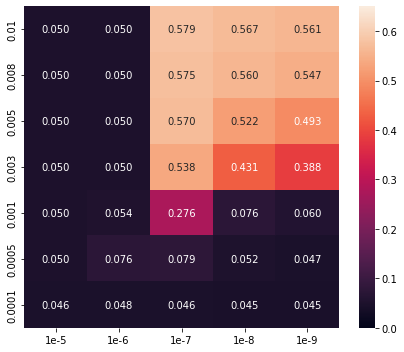

In [ ]:
a = pd.DataFrame(score)
a.columns = ['1e-5', '1e-6', '1e-7', '1e-8', '1e-9']
a.rows = ['0.01', '0.008', '0.005', '0.003', '0.001', '0.0005', '0.0001']
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.axes().set_facecolor('white')
sns.heatmap(a, vmin = 0,vmax=0.65,annot=True, fmt ='.3f', yticklabels=['0.01', '0.008', '0.005', '0.003', '0.001', '0.0005', '0.0001'])
plt.tight_layout()
plt.savefig('tune_lr_l2reg.png')

In [ ]:
for i in score2: ## do not delete this
  for j in i:
    print(j, end = ' ')
  print('\n')

0.46770859768444384 0.5759288138559596 

0.45105616317934893 0.5806013819762684 

0.4897673996315743 0.5779889530058167 



In [ ]:
args2 = deepcopy(args)
model_dir = f'checkpoints/{args2.tgt_market}_{args2.src_markets}_{args2.exp_name}.model'
id_bank_dir = f'checkpoints/{args2.tgt_market}_{args2.src_markets}_{args2.exp_name}.pickle'
with open(id_bank_dir, 'rb') as centralid_file:
    my_id_bank = pickle.load(centralid_file)
mymodel = Model(args, my_id_bank)
mymodel.load(model_dir)

Model is NMF!
NMF(
  (gmf_embedding_user): Embedding(13135, 24)
  (gmf_embedding_item): Embedding(3024, 24)
  (mlp_embedding_user): Embedding(13135, 16)
  (mlp_embedding_item): Embedding(3024, 16)
  (fc_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=24, bias=True)
    (2): Linear(in_features=24, out_features=16, bias=True)
  )
  (affine_output): Linear(in_features=40, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Pretrained weights from checkpoints/t1_none_newera.model are loaded!


In [ ]:
a = mymodel.model.affine_output.weight
list(a.detach().numpy()) ## after decrease negative sample

[array([-3.7795046e-01, -3.4457183e-01, -3.1924966e-01,  3.7405184e-01,
        -3.6592543e-01,  3.3929378e-01,  3.6263445e-01, -3.5807815e-01,
        -3.8204446e-01, -3.1892782e-01,  3.6766115e-01,  3.3093750e-01,
         4.2153841e-01, -3.9577463e-01,  3.4611386e-01,  3.2825613e-01,
        -3.4050366e-01,  3.2440177e-01, -3.3866969e-01, -3.2769167e-01,
        -3.8053679e-01,  3.7522858e-01,  3.2445052e-01, -3.6280113e-01,
         7.9160117e-02,  4.6506548e-01, -4.7372818e-01, -1.2381218e-02,
        -4.4568647e-02,  7.2960079e-01, -2.5297704e-01,  1.0679835e-01,
        -8.5897315e-03, -3.5472799e-04, -6.2426411e-02, -1.7831250e-03,
        -8.4843457e-02,  4.5015950e-02,  5.0447738e-01, -1.0182265e-01],
       dtype=float32)]

In [ ]:
#args.pretrain = f'checkpoints/{args.tgt_market}_{args.src_markets}_{args.exp_name}.model'
args.num_negative = 10
args.num_epoch = 10
args.batch_size = 1024
args.fastmode = True
args.use_qrel = False
build(args)

Running experiment on device: cpu
Loading target market t1: DATA/t1/train_5core.tsv
Loaded target data!

Loading s1: DATA/s1/train_5core.tsv
Loading s2: DATA/s2/train_5core.tsv
Loaded source data!

Model is NMF!
NMF(
  (gmf_embedding_user): Embedding(14984, 20)
  (gmf_embedding_item): Embedding(11074, 20)
  (mlp_embedding_user): Embedding(14984, 20)
  (mlp_embedding_item): Embedding(11074, 20)
  (fc_layers): ModuleList(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=20, bias=True)
  )
  (affine_output): Linear(in_features=40, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
Total Train Loss:  0.03772844553288256  Time:  295.6457488536835
Total Valid Loss:  0.3337777058283488  Time:  0.032622575759887695
--------------------------------------------------------------------------------
Epoch 1 starts !
Total Train Loss:  0.030903027090977624  Time:  29

0.5221056690948465

In [ ]:
args2 = deepcopy(args)
args2.tgt_market = 't2'
args2.src_markets = 's2-s3'
args2.use_qrel = False
args2.pretrain = None
args2.sample_func= lambda:random.uniform(0,0.2)
#args2.pretrain = f'checkpoints/{args2.tgt_market}_{args2.src_markets}_{args2.exp_name}.model'
args2.tgt_market_valid = f'DATA/{args2.tgt_market}/valid_run.tsv'
args2.tgt_market_test = f'DATA/{args2.tgt_market}/test_run.tsv'
args2.idbank_pretrain = None
args2.num_negative = 15
args2.batch_size = 1024
args2.num_epoch = 10
args2.lr = 0.01
args2.fastmode = True
build(args2)

Running experiment on device: cpu
Loading target market t2: DATA/t2/train_5core.tsv
Loaded target data!

Loading s2: DATA/s2/train_5core.tsv
Loading s3: DATA/s3/train_5core.tsv
Loaded source data!

Model is NMF!
NMF(
  (gmf_embedding_user): Embedding(15920, 24)
  (gmf_embedding_item): Embedding(4710, 24)
  (mlp_embedding_user): Embedding(15920, 16)
  (mlp_embedding_item): Embedding(4710, 16)
  (fc_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=24, bias=True)
    (2): Linear(in_features=24, out_features=16, bias=True)
  )
  (affine_output): Linear(in_features=40, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
Total Train Loss:  0.037790112448195114  Time:  183.04605793952942
Total Valid Loss:  0.4817862759033839  Time:  0.06336474418640137
--------------------------------------------------------------------------------
Epoch 1 starts !
Total Train Loss:  0.027865523623337073  Time:  180

0.48043174082500556

In [ ]:
# load pretrained model 
model_dir = f'checkpoints/{args.tgt_market}_{args.src_markets}_{args.exp_name}.model'
id_bank_dir = f'checkpoints/{args.tgt_market}_{args.src_markets}_{args.exp_name}.pickle'

with open(id_bank_dir, 'rb') as centralid_file:
    my_id_bank= pickle.load(centralid_file)

mymodel = Model(args, my_id_bank)
mymodel.load(model_dir)
############
## Target Market Evaluation data
############
tgt_task_generator = TaskGenerator(my_id_bank)
args.batch_size = 2048
#tgt_valid_dataloader = tgt_task_generator.instance_a_market_valid_dataloader(args.tgt_market_valid, args.batch_size)
tgt_test_dataloader = tgt_task_generator.instance_a_market_valid_dataloader(args.tgt_market_test, args.batch_size)
print('loaded target test data!')
test_run_mf = mymodel.predict(tgt_test_dataloader)
write_run_file(test_run_mf, os.path.join('baseline_outputs', args.exp_name, args.tgt_market, 'test_pred.tsv'))
#valid_run_mf = mymodel.predict(tgt_valid_dataloader)
#write_run_file(valid_run_mf, os.path.join('baseline_outputs', args.exp_name, args.tgt_market, 'valid_pred.tsv'))

In [ ]:
# Zip the run files into a single archive to prepare for submission 
run_dir = f'./baseline_outputs/{args.exp_name}/'   
! cd {run_dir} && zip -r ../sample_run.zip ./

print("*** Validating the submission Zip file ***")
# Run the validate_submission.py script to check if the file format is okay and get the performance on validation set.
! python validate_submission.py ./baseline_outputs/sample_run.zip

updating: t2/ (stored 0%)
updating: t2/test_pred.tsv (deflated 67%)
updating: t2/valid_pred.tsv (deflated 67%)
updating: t1/ (stored 0%)
updating: t1/valid_pred.tsv (deflated 67%)
updating: t1/test_pred.tsv (deflated 67%)
*** Validating the submission Zip file ***
Extracting the submission zip file
Validating the file structure of the submission
File structure validation successfully passed
Evaluating the validation set
===================== Market : t1=====================
======= Set val : score(ndcg10_val)=0.799925172797 =======
======= Set val : score(r10_val)=0.906562847608 =======
===================== Market : t2=====================
======= Set val : score(ndcg10_val)=0.756663884838 =======
======= Set val : score(r10_val)=0.888909157242 =======
===================== Market : t1t2=====================
======= Set val : score(ndcg10_val)=0.770929160987 =======
======= Set val : score(r10_val)=0.894730407140 =======


Tuning learning rate và l2 regularization

In [ ]:
#latent15, batchsize1024 epoch15, tuning lr and l2_reg
score = []
for ix, lr in enumerate([0.01, 0.008, 0.005, 0.003, 0.001, 0.0005, 0.0001]):
  score.append([])
  for jx, l2reg in enumerate([1e-5, 1e-6, 1e-7, 1e-8, 1e-9]):
    args.lr = lr
    args.l2_reg = l2reg
    args.exp_name = f'{ix}-lr-{jx}-l2reg'
    ndcg = build(args)
    print(lr, ' learning rate and ', l2reg, ' l2 regularization.')
    score[ix].append(ndcg)

Running experiment on device: cpu
Loading target market t1: DATA/t1/train_5core.tsv
Loaded target data!

Model is GMF!
GMF(
  (embedding_user): Embedding(2698, 15)
  (embedding_item): Embedding(1386, 15)
  (affine_output): Linear(in_features=15, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
Total Train Loss:  0.038956282197503384  Time:  7.755925178527832
Total Valid Loss:  0.6418696045875549  Time:  0.018981456756591797
--------------------------------------------------------------------------------
Epoch 1 starts !
Total Train Loss:  0.03257279715058441  Time:  7.801222324371338
Total Valid Loss:  0.6434077620506287  Time:  0.02399754524230957
--------------------------------------------------------------------------------
Epoch 2 starts !
Total Train Loss:  0.03264277909914095  Time:  7.732277870178223
Total Valid Loss:  0.6434983809789022  Time:  0.02130126953125
--------------------------------------------------------------------------------
Epoch 3 starts 

In [ ]:
#latent15, batchsize1024 epoch15, tuning lr and l2_reg
score = []
for ix, lr in enumerate([0.012, 0.015, 0.018]):
  score.append([])
  for jx, l2reg in enumerate([5e-7, 5e-8]):
    args.lr = lr
    args.l2_reg = l2reg
    args.exp_name = f'{ix}-lr-{jx}-l2reg 2'
    ndcg = build(args)
    print(lr, ' learning rate and ', l2reg, ' l2 regularization.')
    score[ix].append(ndcg)

Running experiment on device: cpu
Loading target market t1: DATA/t1/train_5core.tsv
Loaded target data!

Model is GMF!
GMF(
  (embedding_user): Embedding(2698, 15)
  (embedding_item): Embedding(1386, 15)
  (affine_output): Linear(in_features=15, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
Total Train Loss:  0.03789356245635029  Time:  9.336063385009766
Total Valid Loss:  0.6424116889635721  Time:  0.02127695083618164
--------------------------------------------------------------------------------
Epoch 1 starts !
Total Train Loss:  0.03252841155595316  Time:  9.56802248954773
Total Valid Loss:  0.6217090686162313  Time:  0.02245354652404785
--------------------------------------------------------------------------------
Epoch 2 starts !
Total Train Loss:  0.030198538410878613  Time:  9.350813150405884
Total Valid Loss:  0.48482589920361835  Time:  0.020539045333862305
--------------------------------------------------------------------------------
Epoch 3 star

In [ ]:
#latent15, batchsize1024 epoch15, tuning lr and l2_reg
score3 = []
for ix, bs in enumerate([64,128,256,512,1024,2048]):
  args.batch_size = bs
  args.exp_name = f'{ix}-lr-{jx}-l2reg 2'
  ndcg = build(args)
  print(' Size of batch:', bs)
  score3.append(ndcg)

Running experiment on device: cpu
Loading target market t1: DATA/t1/train_5core.tsv
Loaded target data!

Model is NMF!
NMF(
  (gmf_embedding_user): Embedding(2698, 22)
  (gmf_embedding_item): Embedding(1386, 22)
  (mlp_embedding_user): Embedding(2698, 16)
  (mlp_embedding_item): Embedding(1386, 16)
  (fc_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=24, bias=True)
    (2): Linear(in_features=24, out_features=16, bias=True)
  )
  (affine_output): Linear(in_features=38, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
Total Train Loss:  0.030958372003867828  Time:  25.976855754852295
Total Valid Loss:  0.519029155720112  Time:  0.043285369873046875
--------------------------------------------------------------------------------
Epoch 1 starts !
Total Train Loss:  0.02876296177970881  Time:  26.637532949447632
Total Valid Loss:  0.4300798163857571  Time:  0.039045095443725586
-------------

In [ ]:
score3

[0.5430498536825968,
 0.5751422860715821,
 0.5914806916328903,
 0.5918984571648943,
 0.5896721796201757,
 0.5878254910694235]